# Objective:

**In this notebook, I gonna explain to you how to grid search Best parameters for time series models without a traditional approach, for parameter searching we used optuna. It makes your work easy.**

# Basic of Time Series
* A time series is a sequence of numerical data points in successive order.
* It can be any sales record, or stock price record.

# Table of contents:
* Imports ( data and packages )
* Basic exploration/EDA
* Basic SARIMAX 
* SARIMAX Best Parameter Search
* comaring result's 
* Basic Exponential smoothing
* Best Parameter search for Exponential smoothing
* Conclusion

# Importing dependency

In [1]:
import datetime
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from datetime import datetime
import random
import itertools
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Now I am going to make a parser function that is used to parse your date in the proper formate

def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

## Data: 
In the given data set we have two features **date** and **value**

In [3]:
dff=pd.read_csv("../input/daily-total-female-births-in-california-1959/daily-total-female-births-CA.csv")
df= pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', index_col=0,parse_dates=[0],squeeze=True, date_parser=parser)
df.head()


date
1991-07-01    3.526591
1991-08-01    3.180891
1991-09-01    3.252221
1991-10-01    3.611003
1991-11-01    3.565869
Name: value, dtype: float64

In [4]:
print("Total no of records : ",df.shape[0])

Total no of records :  204


<AxesSubplot:xlabel='date'>

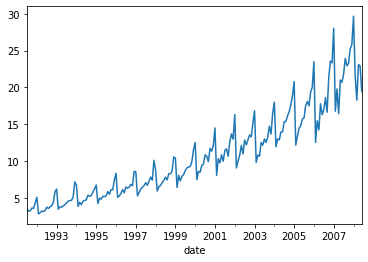

In [5]:
#visulizing the data
df.plot()

## Observation
**Here we can clearly see that over that has the upward trend with the seasonality.**

**Trend →** a general systematic linear or (most often) nonlinear component that changes over time and does not repeat
**Seasonality →** a general systematic linear or (most often) nonlinear component that changes over time and does repeat

So we are using SARIMAX and exponential smoothing since they are working well on-trend and seasonality

In [6]:
#spliting the data into traing and validation set
train_data=df[0:185]
test_data=df[185:]

In [7]:
print("Total no of traing simple :",train_data.shape[0])

Total no of traing simple : 185


In [8]:
print("Total no of testing simple :",test_data.shape[0])

Total no of testing simple : 19


# Basic SARIMA

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. ... Therefore, we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA. Another seasonal equivalent model holds the seasonal pattern; it can also deal with external effects

Model Tuning Parameters
1. endog: array_like
The observed time-series process

2. exog: array_like, optional
Array of exogenous regressors, shaped nobs x k.

3. order: iterable or iterable of iterables, optional
The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

4. seasonal_order: iterable, optional
The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

5. trend: str{‘n’,’c’,’t’,’ct’} or iterable, optional
Parameter controlling the deterministic trend polynomial . Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both. Can also be specified as an iterable defining the non-zero polynomial exponents to include, in increasing order. For example, [1,1,0,1] denotes . Default is to not include a trend component.

Refer to the official documentation at [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) for more parameters and information

### Let's code

In [9]:
my_order = (1,0,0)
my_seasonal_order = (2, 0, 0, 12)
#initializing  the model
model_11 = SARIMAX(train_data,order=my_order, seasonal_order=my_seasonal_order)
# Now fiting the model
model_fit = model_11.fit(disp=0)

In [10]:
#summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  185
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -262.438
Date:                            Tue, 03 May 2022   AIC                            532.877
Time:                                    07:14:38   BIC                            545.758
Sample:                                07-01-1991   HQIC                           538.097
                                     - 11-01-2006                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8496      0.038     22.216      0.000       0.775       0.925
ar.S.L12       0.9021      0.080   

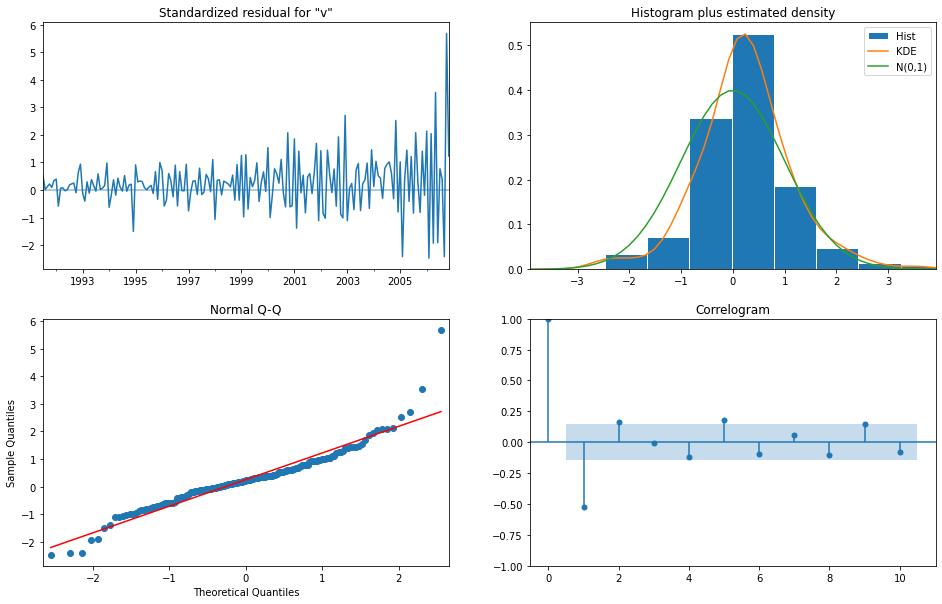

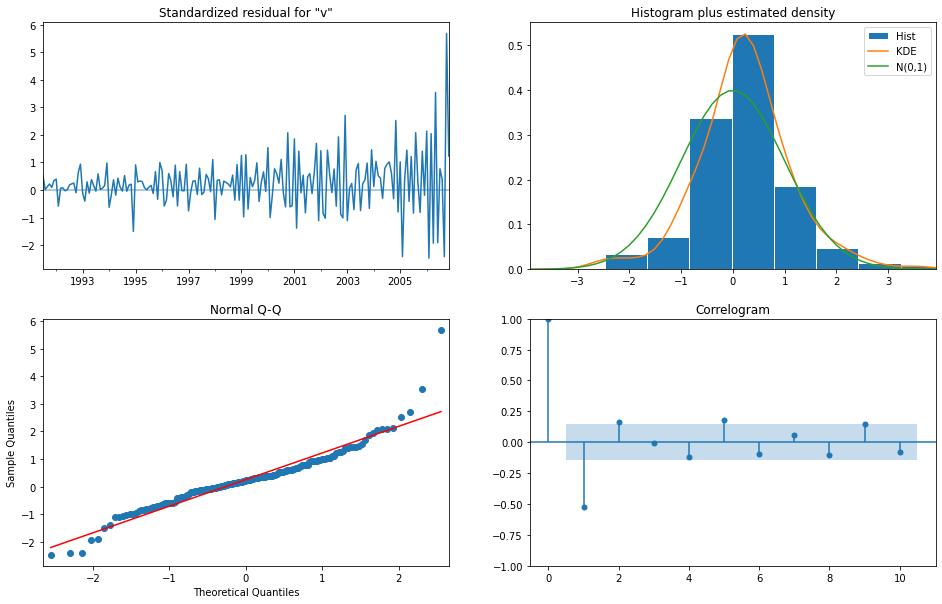

In [11]:
model_fit.plot_diagnostics(figsize=(16,10))

In [12]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [13]:
print("mean absolute error :- ",round(mean_absolute_error(test_data, residuals),5))
print("mean squared error :- ",round(mean_squared_error(test_data, residuals),5))
print("Root mean squared error :- ",round(mean_squared_error(test_data, residuals,squared=False),5))

mean absolute error :-  19.03622
mean squared error :-  374.11024
Root mean squared error :-  19.34193


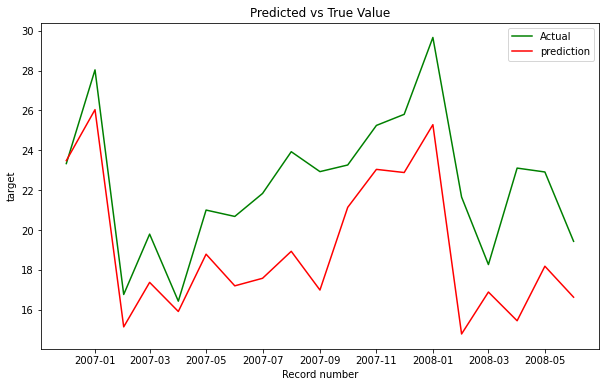

In [14]:
plt.figure(figsize=(10,6))
plt.plot(test_data, color = "green")
plt.plot(predictions, color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel("target")
plt.show()

# SARIMAX Best Parameter Search
For SARIMAX Parameter Search we used optuna. Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
we take 10 trial to find best param

In [15]:
#Generate all different combinations of p, d and q triplets
#Generate all different combinations of p, d, q and s triplets
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
    model=SARIMAX(train_data,order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
    mdl = model.fit(disp=0) #disp=0
    predictions = mdl.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    mse=np.sqrt(np.mean(residuals**2))
    accuracy=mse
    return accuracy
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=10)
    

[I 2022-05-03 07:14:40,437] A new study created in memory with name: no-name-9715be88-3f20-4336-9132-29c41119f776
[I 2022-05-03 07:14:41,028] Trial 0 finished with value: 2.6822313963647346 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 0, 1, 12), 'trend': 'n'}. Best is trial 0 with value: 2.6822313963647346.
[I 2022-05-03 07:14:42,437] Trial 1 finished with value: 1.9391043216534125 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 12), 'trend': 't'}. Best is trial 1 with value: 1.9391043216534125.
[I 2022-05-03 07:14:46,738] Trial 2 finished with value: 1.9774558945791372 and parameters: {'order': (1, 1, 0), 'seasonal_order': (1, 2, 2, 12), 'trend': None}. Best is trial 1 with value: 1.9391043216534125.
[I 2022-05-03 07:14:48,220] Trial 3 finished with value: 2.5850478784346875 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 0, 2, 12), 'trend': 'ct'}. Best is trial 1 with value: 1.9391043216534125.
[I 2022-05-03 07:14:50,832] Trial 4 finished wit

In [17]:
trial=study.best_trial
print("Accuracy: {}".format(trial.value))
print("best params for SARIMAX: {}".format(trial.params))

Accuracy: 1.9391043216534125
best params for SARIMAX: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 12), 'trend': 't'}


# Comaring result's
* Now you can clearly see that over basic model has **RMSE :- 19.34193**
* after the parameter search we can reduce it to **RMSE :- 2.14445**


So, It is clear that we can effectively tune our the model using optuna without using any traditional approach for finding the parameter

# Exponential smoothing
## on default parameter
Exponential smoothing is a time series forecasting method for univariate data.

Time series methods like the Box-Jenkins ARIMA family of methods develop a model where the prediction is a weighted linear sum of recent past observations or lags.

Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations.

Specifically, past observations are weighted with a geometrically decreasing ratio.

Refer to the official documentation at [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html) for more parameters and information


In [18]:
##initializing  the model

model2=ExponentialSmoothing(train_data,initialization_method='estimated').fit(optimized=True)
prediction = model2.forecast(len(test_data))
prediction = pd.Series(prediction, index=test_data.index)
y_pred = test_data - predictions

In [19]:
print("mean absolute error :- ",round(mean_absolute_error(test_data, y_pred),5))
print("mean squared error :- ",round(mean_squared_error(test_data, y_pred),5))
print("Root mean squared error :- ",round(mean_squared_error(test_data, y_pred,squared=False),5))

mean absolute error :-  19.03622
mean squared error :-  374.11024
Root mean squared error :-  19.34193


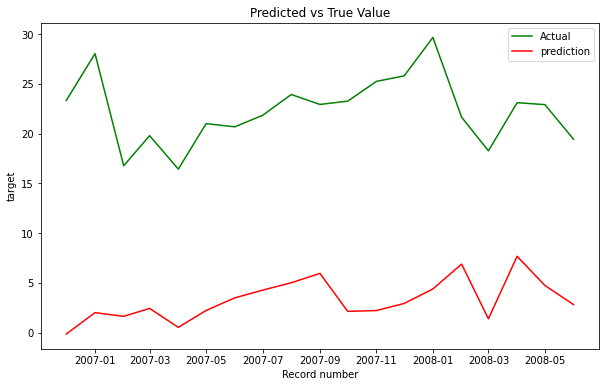

In [20]:
plt.figure(figsize=(10,6))
plt.plot(test_data, color = "green")
plt.plot(y_pred, color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel("target")
plt.show()

# ExponentialSmoothing best parameter search

For that we used optuna similarly we previously do for SRIMAX

In [21]:
def objective_smoothing(trial):
    X,y=train_data,train_data
    seasonal=trial.suggest_categorical("seasonal",['add','mul',None])
    trend=trial.suggest_categorical("trend",['add','mul',None])
    initialization_method=trial.suggest_categorical("initialization_method",['estimated','heuristic'])
    mdl=ExponentialSmoothing(train_data,trend=trend,seasonal=seasonal,initialization_method=initialization_method)
    mdl = mdl.fit(optimized=True) #disp=0
    predictions = mdl.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    mse=np.sqrt(np.mean(residuals**2))
    accuracy=mse
    return accuracy
studys=optuna.create_study(direction="minimize")
studys.optimize(objective_smoothing,n_trials=10)

[I 2022-05-03 07:14:53,432] A new study created in memory with name: no-name-a8db4c1c-bd7b-4be8-a30b-7428d904be69
[W 2022-05-03 07:14:53,717] Trial 0 failed, because the objective function returned nan.
[W 2022-05-03 07:14:54,000] Trial 1 failed, because the objective function returned nan.
[I 2022-05-03 07:14:54,162] Trial 2 finished with value: 2.9472139464658125 and parameters: {'seasonal': 'add', 'trend': 'add', 'initialization_method': 'heuristic'}. Best is trial 2 with value: 2.9472139464658125.
[I 2022-05-03 07:14:54,206] Trial 3 finished with value: 3.5948140868378484 and parameters: {'seasonal': 'add', 'trend': None, 'initialization_method': 'estimated'}. Best is trial 2 with value: 2.9472139464658125.
[W 2022-05-03 07:14:54,370] Trial 4 failed, because the objective function returned nan.
[W 2022-05-03 07:14:54,656] Trial 5 failed, because the objective function returned nan.
[W 2022-05-03 07:14:54,821] Trial 6 failed, because the objective function returned nan.
[I 2022-05-0

In [22]:
trial=studys.best_trial
print("Accuracy: {}".format(trial.value))
print("best params: {}".format(trial.params))

Accuracy: 2.619021677604755
best params: {'seasonal': 'add', 'trend': 'mul', 'initialization_method': 'estimated'}


* Now you can clearly see that over basic model has **RMSE :- 19.34193**
* after the parameter search we can reduce it to **RMSE :- 2.6190216**

# Conclusion
So, It is clear that we can effectively tune our the model using optuna without using any traditional approach for finding the parameter
Reference: [here](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b)

## Please do upvote if you find this notebook useful and comment out your douts.